# Testovací úloha

### Dataset
Vyvtořil jsem dataset skládající se z fotografií 52 obalů knih, letáků, plakátů a obrazů. Každá z fotografií je pořízena jednou fotoaparátem na mobilním telefonu LG bez použití blesku a dvakrát mobilním telefonem Xiaomi, jednou s použitím blesku a jednou bez použití blesku. Následně jsem všechny fotografie ořezal tak, abych získal jejich overview, neboli "bird eye view" pomocí skriptu `warp.py`. Po jeho spuštění s názvem obrazového souboru (s příponou jpg, png,...) se otevře okno, kde se zobrazí vstupní obraz a po zvolení čtyřech bodů je čtyřúhelník vyznačený těmito body transformován na obdélník a uložen na disk. Celý dataset se tedy skládá ze 156 obrázků.

### Extrakce feature vectoru
Pro získání feature vectoru jsem se rozhodl použít Pytorch spolu s některým z předtrénovaných modelů (natrénovaných na ImageNet) dostupných v Torchvision. Z modelu místo poslední softmax vrstvy vezmu výstup předposlední vrstvy, který má typicky délku 512 až 2048 jako číselnou reprezentaci obrazu, neboli embedding.

### Vyhodnocení
Nejdříve jsem získal feature vector všech obrázků v datasetu a následně jsem použil klasifikátory k-NN, GaussianMixture s RBF kernelem a MLP (neuronová síť). Vzhledem k tomu, že všechny tři klasifikátory na tomto datasetu fungovaly bezchybně a nebylo by tak co porovnávat, přidal jsem do transformací operace ColorJitter, která mění náhodně jas, saturaci a odstín v rozsahu +/- 0.5 a random grayscale, která převede obrázek na černobílý s P(0.3). Klasifikátor k-NN jsem zvolil, protože svým fungováním je nejblíže k fungování systému pro vyhledávání obrázků podle feature vectoru. GaussianMixture s RBF (s tímto nastavením) jsem vybral, protože někdo to prohrát musí a MLP si i s náhodnou operací nad datasetem poradí zpravidla bez problémů.

Pro vyhodnocení jsem použil precision recall curve, confusion matrix a classification report, ve kterém jsou zobrazení hodnoty precision, recall a f1-score pro jednotlivé třídy a pak pro micro a macro average všech tříd.

In [34]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import os
import pandas as pd
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
from fine_tuning_config_file import *
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import binarize
import scikitplot as skplt

In [46]:
# třída, která doplní obrázek na čtverec
class PadToSquare(object):

    def __call__(self, img):
        old_size = np.shape(img)  # old_size[0] is in (width, height) format
        desired_size = max(old_size[0], old_size[1])
        #print('old_size: {}, desired_size: {}'.format(old_size,desired_size))

        new_im = Image.new("RGB", (desired_size, desired_size))
        new_im.paste(img, ((desired_size-old_size[1])//2,
                    (desired_size-old_size[0])//2))
        return new_im

# transfromace provedené nad datasetem při inferenci modelem
data_transforms = {
    'transformed_dataset': transforms.Compose([
        PadToSquare(),
        transforms.Resize(224),
        transforms.ColorJitter(brightness=0.5,saturation=0.5,contrast=0.5,hue=0.5),
        transforms.RandomGrayscale(p=0.5),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Třída, která zkrátí model o jednu vrstvu
class ResNetBottom(nn.Module):
    def __init__(self, original_model):
        super(ResNetBottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        
    def forward(self, x):
        x = self.features(x)
        return x

# pomocná funkce pro zobrazení obrázku
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [52]:
data_dir = DATA_DIR
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['transformed_dataset', 'test_dataset']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=BATCH_SIZE,
                                               shuffle=True, num_workers=25)
                for x in ['transformed_dataset', 'test_dataset']}
dset_sizes = {x: len(dsets[x]) for x in ['transformed_dataset', 'test_dataset']}
dset_classes = dsets['transformed_dataset'].classes

In [58]:
# inicializace resnet modelu, načtení vah natrénovaných na ImageNet datasetu, zkrácení modelu o jednu vrstu a přepnutí na evaluaci
res_model = models.resnet18(pretrained=True)
res_conv2 = ResNetBottom(res_model)
res_conv2.eval()

# output obsahuje feature vector všech obrázků a labellist obsahuje příslušnost k třídě
output = list()
labellist = list()
for images, labels in dsets['transformed_dataset']:
    embed = res50_conv2(images.unsqueeze(0))
    output.append(embed.squeeze().detach().numpy())
    labellist.append(labels)

## Klasifikátor k-NN

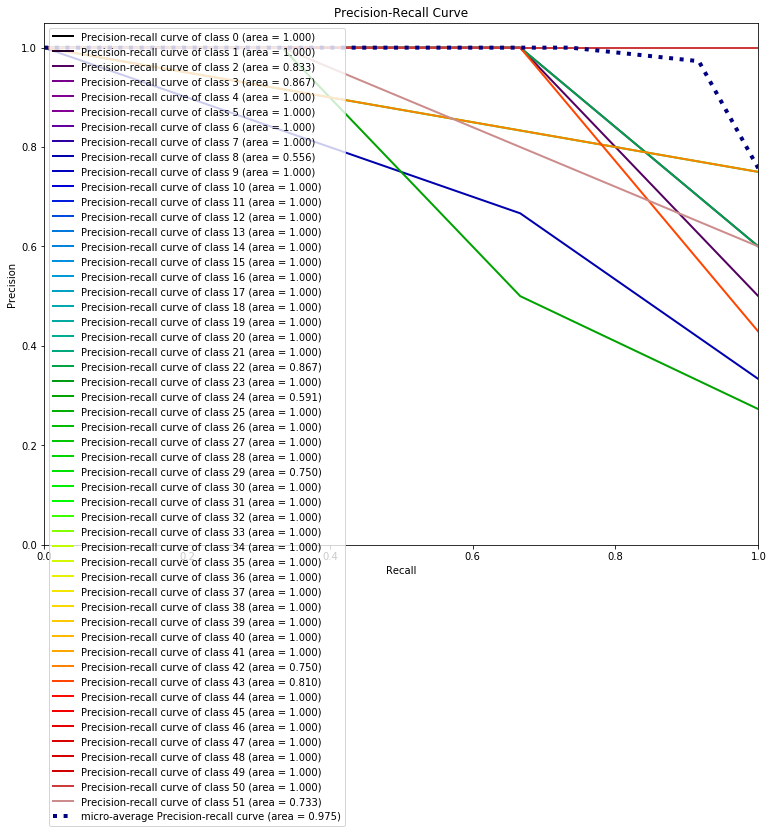

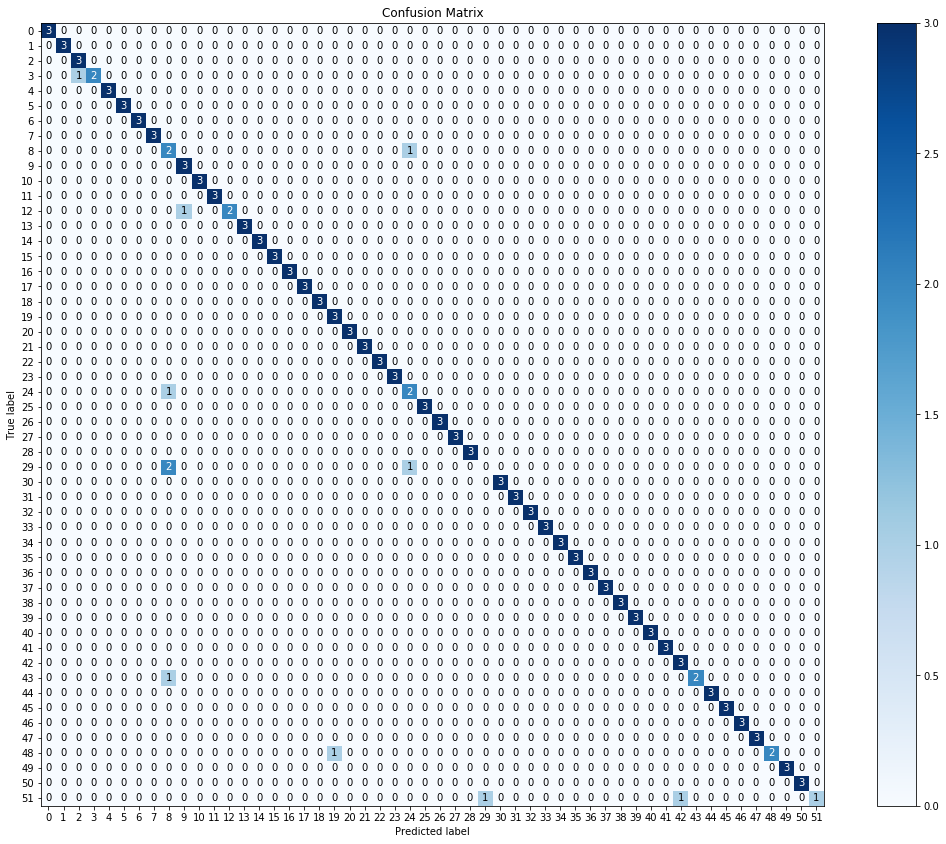

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       0.75      1.00      0.86         3
           3       1.00      0.67      0.80         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       0.33      0.67      0.44         3
           9       0.75      1.00      0.86         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      0.67      0.80         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
          17       1.00    

In [55]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import classification_report

nbrc = KNeighborsClassifier(3).fit(output,labellist)
y_pred = nbrc.predict(output)
y_proba = nbrc.predict_proba(output)

skplt.metrics.plot_precision_recall(labellist, y_proba,figsize=[2*6.4, 2*4.8])
plt.show()

skplt.metrics.plot_confusion_matrix(labellist, y_pred, normalize=False,figsize=[3*6.4, 3*4.8])
plt.show()

report = metrics.classification_report(labellist,y_pred)
print(report)

## Klasifikátor GaussianMixture s RBF kernelem

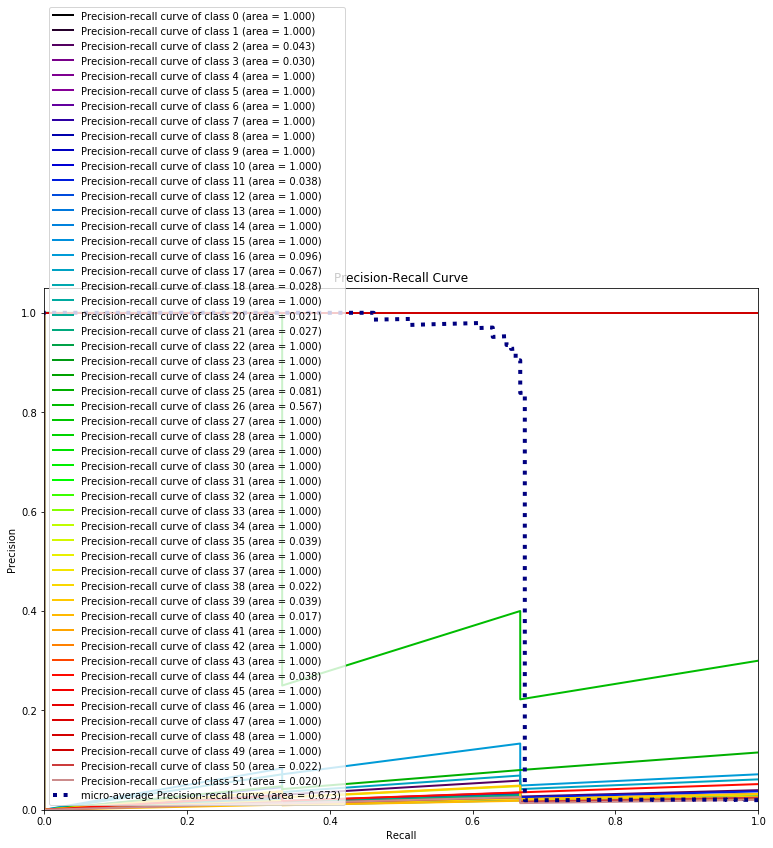

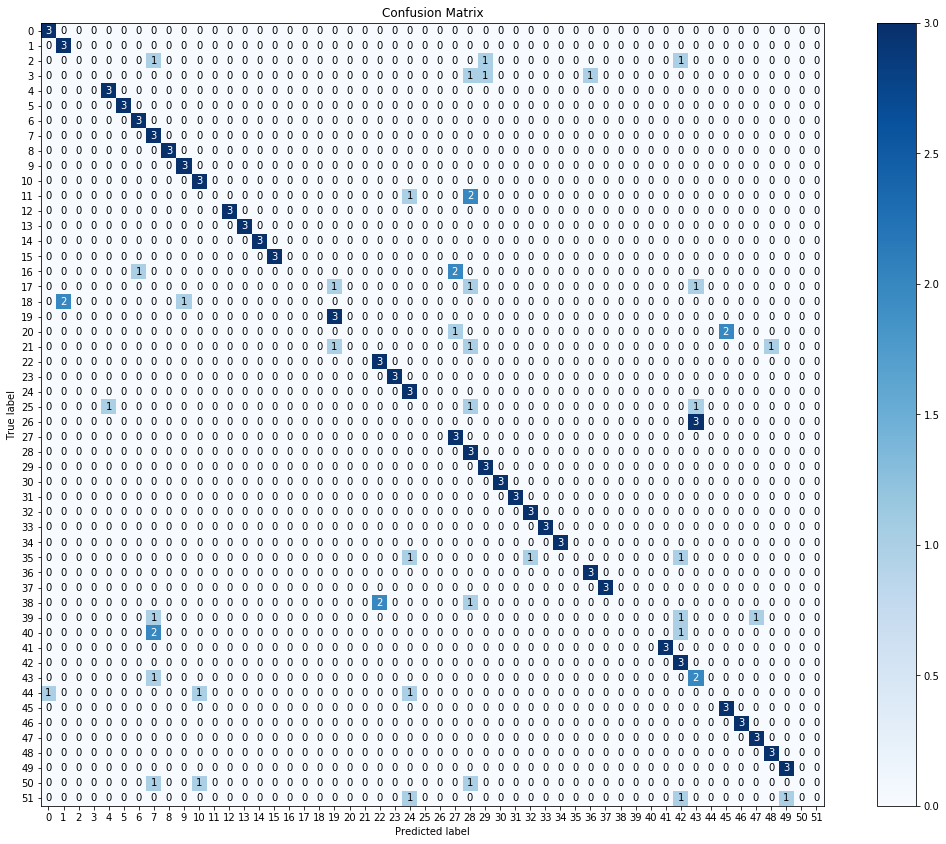

C:\Users\michal.DESKTOP-A2GI0VC\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.60      1.00      0.75         3
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         3
           6       0.75      1.00      0.86         3
           7       0.33      1.00      0.50         3
           8       1.00      1.00      1.00         3
           9       0.75      1.00      0.86         3
          10       0.60      1.00      0.75         3
          11       0.00      0.00      0.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       0.00      0.00      0.00         3
          17       0.00    

In [56]:
rbfc = GaussianProcessClassifier(1.0 * RBF(1.0)).fit(mrd,labellist)
y_pred = rbfc.predict(output)
y_proba = rbfc.predict_proba(output)

skplt.metrics.plot_precision_recall(labellist, y_proba,figsize=[2*6.4, 2*4.8])
plt.show()

skplt.metrics.plot_confusion_matrix(labellist, y_pred, normalize=False,figsize=[3*6.4, 3*4.8])
plt.show()
report = metrics.classification_report(labellist,y_pred)
print(report)

## Klasifikátor MLP

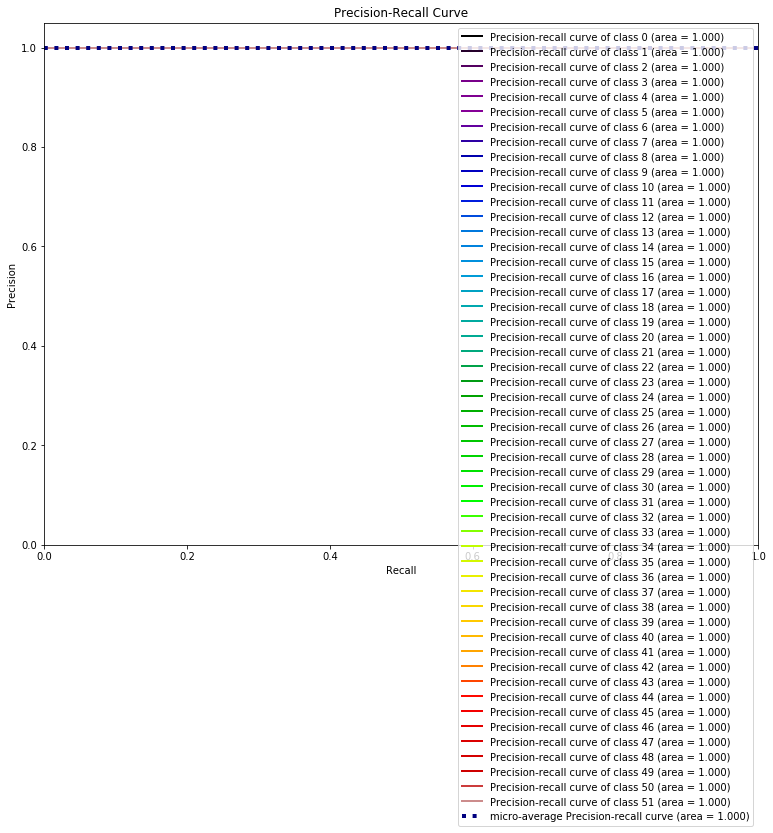

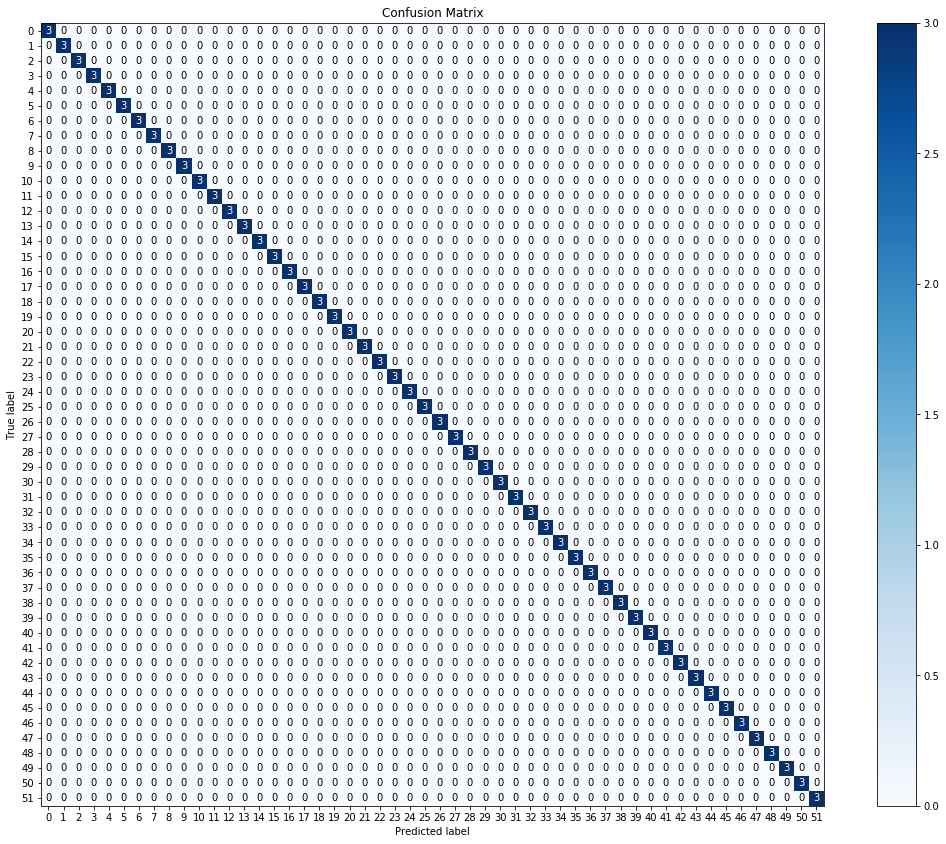

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
          17       1.00    

In [57]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(alpha=1, max_iter=1000).fit(output,labellist)
y_pred = mlpc.predict(output)
y_proba = mlpc.predict_proba(output)

skplt.metrics.plot_precision_recall(labellist, y_proba,figsize=[2*6.4, 2*4.8])
plt.show()

skplt.metrics.plot_confusion_matrix(labellist, y_pred, normalize=False,figsize=[3*6.4, 3*4.8])
plt.show()

report = metrics.classification_report(labellist,y_pred)
print(report)

## Výsledek
Vzhledem k tomu, že před získání feature vectoru provádím náhodnou operaci pro zkleslení obrázků, výsledky se můžou lišit mezi spuštěními. Obecně ale vychází jako nejlepší klasifikátor MLP, potom k-NN a následně GaussianMixture s RBF kernelem (někdy ale i ten zkonverguje pěkně).  